# ltu-ili jupyter interface
This is a tutorial for using the ltu-ili inference framework in a jupyter notebook. 

This notebook assumes you have installed the ltu-ili package from the installation instructions in [INSTALL.md](../INSTALL.md).

In [3]:
%load_ext autoreload
%autoreload 2

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import os
import numpy as np

# seaparate into train and test set.
from sklearn.model_selection import train_test_split

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import torch
from torch.distributions import Uniform, ExpTransform, TransformedDistribution #, AffineTransform

import torch.nn as nn

import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

from sbi.utils.user_input_checks import process_prior

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device: cuda


# Get theta

In [4]:
df_pars = pd.read_csv('/disk/xray15/aem2/camels/LH/CosmoAstroSeed_IllustrisTNG_L25n256_LH.txt', delim_whitespace=True)
df_pars

,#Name,Omega_m,sigma_8,A_SN1,A_AGN1,A_SN2,A_AGN2,seed
0,LH_0,0.3090,0.9790,3.11234,1.12194,0.66850,0.53182,0
1,LH_1,0.3026,0.9394,3.42001,3.96137,1.03311,1.16070,1
2,LH_2,0.4282,0.7530,0.70613,0.37423,1.96292,0.62720,2
3,LH_3,0.1906,0.6286,1.60882,0.39887,0.86634,0.86634,3
4,LH_4,0.1382,0.6874,1.19914,0.27586,0.82188,0.91700,4
...,...,...,...,...,...,...,...,...
995,LH_995,0.1342,0.7202,0.48163,0.25174,1.74231,0.76684,995
996,LH_996,0.1854,0.7978,0.30566,1.79751,1.51887,0.53403,996
997,LH_997,0.1582,0.7854,0.93952,2.23148,1.85446,1.32961,997
998,LH_998,0.3854,0.9778,0.93692,0.42869,1.48761,1.32042,998


In [5]:
theta = df_pars[['Omega_m', 'sigma_8', 'A_SN1', 'A_AGN1', 'A_SN2', 'A_AGN2']].to_numpy()
print(theta)
print(theta.shape)

[[0.309   0.979   3.11234 1.12194 0.6685  0.53182]
 [0.3026  0.9394  3.42001 3.96137 1.03311 1.1607 ]
 [0.4282  0.753   0.70613 0.37423 1.96292 0.6272 ]
 ...
 [0.1582  0.7854  0.93952 2.23148 1.85446 1.32961]
 [0.3854  0.9778  0.93692 0.42869 1.48761 1.32042]
 [0.4322  0.6142  1.28521 0.35799 1.1591  0.86754]]
(1000, 6)


# Get data (x)

In [6]:
import os
import pandas as pd

# Define the directory containing the LH_X files
directory = "/disk/xray15/aem2/camels/LH/get_LF/output/"

# Get all files in the directory
files = os.listdir(directory)

# Filter out files that start with "LH_" and end with ".txt"
LH_X_files = [file for file in files if file.startswith("LH_") and file.endswith(".txt")]

# Initialize lists to store data
phia = []
phi_sigmaa = []
hista = []
binsa = []
LH_X_values = []

# Iterate over LH_X files
for LH_X_file in LH_X_files:
    # Define the file path
    file_path = os.path.join(directory, LH_X_file)
    
    # Extract LH_X value from the file name (remove the ".txt" extension)
    LH_X = LH_X_file[:-4]
    
    # Initialize an empty dictionary to store variable names and their values
    variable_data = {}

    # Open the text file for reading
    with open(file_path, 'r') as file:
        # Initialize variables to store the current variable name and its values
        current_variable_name = None
        current_variable_values = []

        # Iterate over each line in the file
        for line in file:
            # Remove leading and trailing whitespace from the line
            line = line.strip()

            # Check if the line is empty
            if not line:
                continue

            # Check if the line is a variable name
            if line in ['phi', 'phi_sigma', 'hist', 'massBinLimits']:
                # If it's a new variable name, update the current variable name and reset the values list
                if current_variable_name is not None:
                    variable_data[current_variable_name] = current_variable_values
                    current_variable_values = []

                current_variable_name = line
            else:
                # If it's not a variable name, convert the value to float and append it to the values list
                current_variable_values.append(float(line))

        # Add the last variable data to the dictionary
        if current_variable_name is not None:
            variable_data[current_variable_name] = current_variable_values
        
        # Extract specific variables
        phi = variable_data.get('phi')
        phi_sigma = variable_data.get('phi_sigma')
        hist = variable_data.get('hist')
        bins = variable_data.get('massBinLimits')

        phia.append(phi)
        phi_sigmaa.append(phi_sigma)
        hista.append(hist)
        binsa.append(bins)
        LH_X_values.append(LH_X)

# Create a DataFrame from the lists
df_x = pd.DataFrame({'LH_X': LH_X_values, 'phi': phia, 'phi_sigma': phi_sigmaa, 'hist': hista, 'bins': binsa})

# Sort the DataFrame by the numerical value in the LH_X column
df_x['LH_X_num'] = df_x['LH_X'].apply(lambda x: int(x.split('_')[1]))
df_x = df_x.sort_values(by='LH_X_num').drop(columns='LH_X_num')

# Reset index after sorting
df_x = df_x.reset_index(drop=True)

# Display the DataFrame
df_x


,LH_X,phi,phi_sigma,hist,bins
0,LH_0,"[0.00015987453159307786, 0.0002213647360519539...","[4.434121702304844e-05, 5.217616865930228e-05,...","[13.0, 18.0, 23.0, 23.0, 24.0, 18.0, 15.0, 9.0...","[-22.0, -21.5, -21.0, -20.5, -20.0, -19.5, -19..."
1,LH_1,"[1.2298040891775219e-05, 1.2298040891775219e-0...","[1.2298040891775219e-05, 1.2298040891775219e-0...","[1.0, 1.0, 5.0, 7.0, 23.0, 13.0, 16.0, 9.0, 11...","[-22.0, -21.5, -21.0, -20.5, -20.0, -19.5, -19..."
2,LH_2,"[3.689412267532566e-05, 1.2298040891775219e-05...","[2.1300831658114343e-05, 1.2298040891775219e-0...","[3.0, 1.0, 1.0, 7.0, 17.0, 25.0, 22.0, 34.0, 3...","[-22.0, -21.5, -21.0, -20.5, -20.0, -19.5, -19..."
3,LH_3,"[2.4639824589630805e-05, 8.623938606370782e-05...","[1.7422987054574983e-05, 3.259542410620862e-05...","[2.0, 7.0, 9.0, 6.0, 14.0, 10.0, 7.0, 5.0, 8.0...","[-22.0, -21.5, -21.0, -20.5, -20.0, -19.5, -19..."
4,LH_4,"[0.0001229804089177522, 0.00014757649070130263...","[3.888981997589799e-05, 4.2601663316228686e-05...","[10.0, 12.0, 15.0, 13.0, 18.0, 8.0, 11.0, 5.0,...","[-22.0, -21.5, -21.0, -20.5, -20.0, -19.5, -19..."
...,...,...,...,...,...
995,LH_995,"[1.2319912294815403e-05, 7.391947376889241e-05...","[1.2319912294815403e-05, 3.0177498798138694e-0...","[1.0, 6.0, 10.0, 11.0, 25.0, 25.0, 21.0, 18.0,...","[-22.0, -21.5, -21.0, -20.5, -20.0, -19.5, -19..."
996,LH_996,"[1.2319912294815403e-05, 7.391947376889241e-05...","[1.2319912294815403e-05, 3.0177498798138694e-0...","[1.0, 6.0, 15.0, 38.0, 51.0, 47.0, 38.0, 43.0,...","[-22.0, -21.5, -21.0, -20.5, -20.0, -19.5, -19..."
997,LH_997,"[1.2319912294815403e-05, 0.0, 8.62393860637078...","[1.2319912294815403e-05, 0.0, 3.25954241062086...","[1.0, 0.0, 7.0, 11.0, 13.0, 15.0, 10.0, 18.0, ...","[-22.0, -21.5, -21.0, -20.5, -20.0, -19.5, -19..."
998,LH_998,"[0.0, 4.9192163567100876e-05, 9.83843271342017...","[0.0, 2.4596081783550438e-05, 3.47841124395348...","[0.0, 4.0, 8.0, 14.0, 21.0, 28.0, 24.0, 25.0, ...","[-22.0, -21.5, -21.0, -20.5, -20.0, -19.5, -19..."


In [7]:
# transform x data into log space.

In [8]:
df_x['phi']

0      [0.00015987453159307786, 0.0002213647360519539...
1      [1.2298040891775219e-05, 1.2298040891775219e-0...
2      [3.689412267532566e-05, 1.2298040891775219e-05...
3      [2.4639824589630805e-05, 8.623938606370782e-05...
4      [0.0001229804089177522, 0.00014757649070130263...
                             ...                        
995    [1.2319912294815403e-05, 7.391947376889241e-05...
996    [1.2319912294815403e-05, 7.391947376889241e-05...
997    [1.2319912294815403e-05, 0.0, 8.62393860637078...
998    [0.0, 4.9192163567100876e-05, 9.83843271342017...
999    [4.9192163567100876e-05, 3.689412267532566e-05...
Name: phi, Length: 1000, dtype: object

In [9]:
type(df_x['phi'])

pandas.core.series.Series

In [10]:
# clean up 0 values to avoid nan/-inf values when logging

# Function to replace 0 or negative values with 1
def replace_zeros(phi_list):
    # set as 1e-5 for now:
    return [1e-5 if x == 0 else x for x in phi_list]

# Apply the function to each entry in the 'phi' column
df_x['phi_0s'] = df_x['phi'].apply(replace_zeros)
df_x['phi_0s']

0      [0.00015987453159307786, 0.0002213647360519539...
1      [1.2298040891775219e-05, 1.2298040891775219e-0...
2      [3.689412267532566e-05, 1.2298040891775219e-05...
3      [2.4639824589630805e-05, 8.623938606370782e-05...
4      [0.0001229804089177522, 0.00014757649070130263...
                             ...                        
995    [1.2319912294815403e-05, 7.391947376889241e-05...
996    [1.2319912294815403e-05, 7.391947376889241e-05...
997    [1.2319912294815403e-05, 1e-05, 8.623938606370...
998    [1e-05, 4.9192163567100876e-05, 9.838432713420...
999    [4.9192163567100876e-05, 3.689412267532566e-05...
Name: phi_0s, Length: 1000, dtype: object

In [11]:
# convert pandas series to np.array
x = np.log10((np.array(df_x['phi_0s'].tolist())))
print(x)

[[-3.79622071 -3.65489156 -3.54843623 ... -3.91016407 -3.95592156
  -4.00707408]
 [-4.91016407 -4.91016407 -4.21119406 ... -3.86877138 -3.83098282
  -3.95592156]
 [-4.43304281 -4.91016407 -4.91016407 ... -3.31909946 -3.22892283
  -3.30810408]
 ...
 [-4.90939238 -5.         -4.06429434 ... -3.7052724  -3.5669697
  -3.8679997 ]
 [-5.         -4.30810408 -4.00707408 ... -3.51222406 -3.4788003
  -3.4788003 ]
 [-4.30810408 -4.43304281 -3.95592156 ... -3.67971515 -3.60913407
  -3.54843623]]


## Toy NPE
This example attempts to infer 3 unknown parameters from a 20-dimensional 1D data vector using amortized posterior inference. We train the models from a simple synthetic catalog. This tutorial mirrors the same configuration as in [examples/toy_sbi.py](../examples/toy_sbi.py), but demonstrates how one would interact with the inference pipeline in a jupyter notebook.

(array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100.]),
 array([0.1002 , 0.14016, 0.18012, 0.22008, 0.26004, 0.3    , 0.33996,
        0.37992, 0.41988, 0.45984, 0.4998 ]),
 <BarContainer object of 10 artists>)

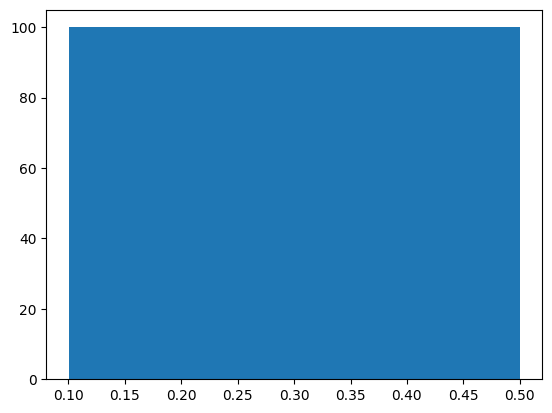

In [12]:
# prior for omega m, between 0.1 and 0.5
plt.hist(theta[:, 0])

(array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100.]),
 array([0.6002 , 0.64016, 0.68012, 0.72008, 0.76004, 0.8    , 0.83996,
        0.87992, 0.91988, 0.95984, 0.9998 ]),
 <BarContainer object of 10 artists>)

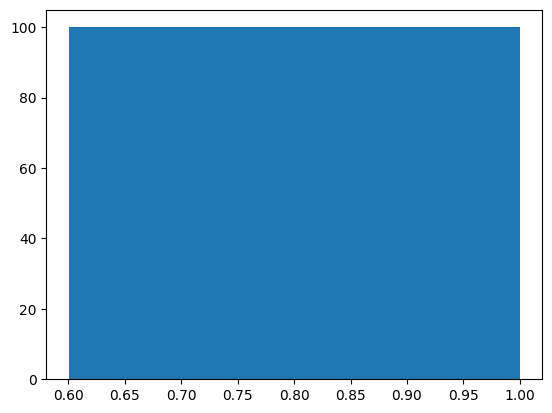

In [13]:
# prior for sigma_8, between 0.6 and 1
plt.hist(theta[:, 1])

(array([330., 170., 114.,  87.,  70.,  59.,  50.,  45.,  39.,  36.]),
 array([0.25035 , 0.624761, 0.999172, 1.373583, 1.747994, 2.122405,
        2.496816, 2.871227, 3.245638, 3.620049, 3.99446 ]),
 <BarContainer object of 10 artists>)

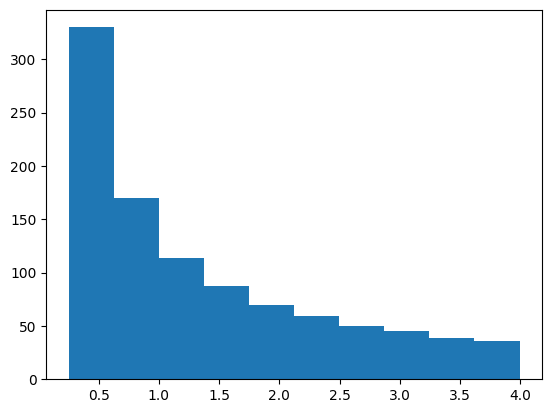

In [14]:
# prior for A_SN1, between 0.25 and 4
plt.hist(theta[:, 2])

(array([330., 170., 114.,  87.,  70.,  59.,  50.,  45.,  39.,  36.]),
 array([0.25035 , 0.624761, 0.999172, 1.373583, 1.747994, 2.122405,
        2.496816, 2.871227, 3.245638, 3.620049, 3.99446 ]),
 <BarContainer object of 10 artists>)

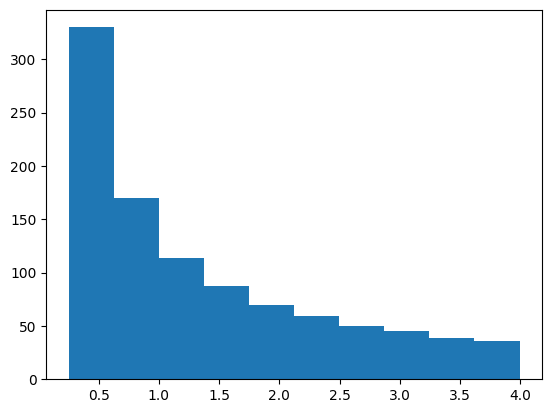

In [15]:
# prior for A_AGN1, between 0.25 and 4
plt.hist(theta[:, 3])

(array([189., 150., 124., 106.,  92.,  81.,  74.,  66.,  61.,  57.]),
 array([0.50035 , 0.650176, 0.800002, 0.949828, 1.099654, 1.24948 ,
        1.399306, 1.549132, 1.698958, 1.848784, 1.99861 ]),
 <BarContainer object of 10 artists>)

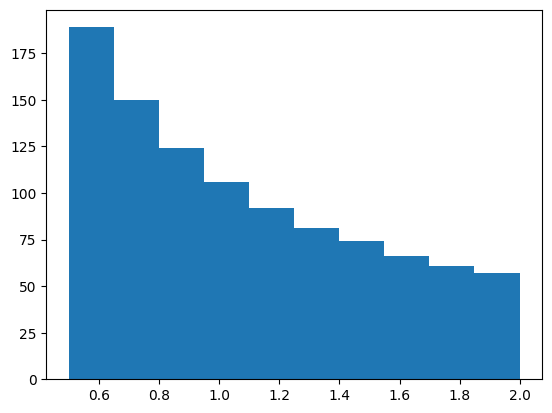

In [16]:
# prior for A_SN2, between 0.5 and 2
plt.hist(theta[:, 4])

(array([189., 150., 124., 106.,  92.,  81.,  74.,  66.,  61.,  57.]),
 array([0.50035 , 0.650176, 0.800002, 0.949828, 1.099654, 1.24948 ,
        1.399306, 1.549132, 1.698958, 1.848784, 1.99861 ]),
 <BarContainer object of 10 artists>)

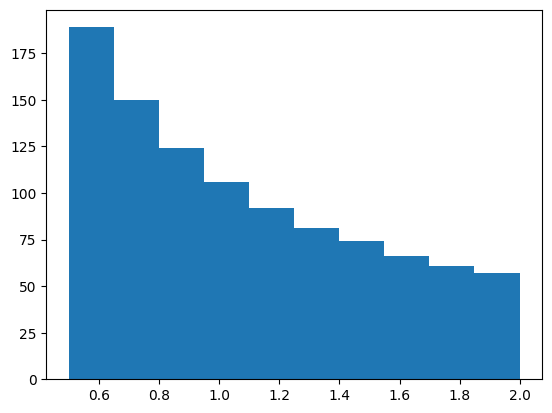

In [17]:
# prior for A_AGN2, between 0.5 and 2
plt.hist(theta[:, 5])

In [18]:
from sklearn.model_selection import train_test_split

# Assuming x and theta are your data arrays
# First split: into train+validation and test sets
# can stratify the sets you pick to train but in this case we are OK for now to make random selection (fixed random selection)
x_temp, x_test, theta_temp, theta_test = train_test_split(x, theta, test_size=0.2, random_state=0)

# Second split: into train and validation sets
x_train, x_val, theta_train, theta_val = train_test_split(x_temp, theta_temp, test_size=0.25, random_state=0)  # 0.25 x 0.8 = 0.2

print('x: full data:', x.shape)
print('x: training set:', x_train.shape)
print('x: validation set:', x_val.shape)
print('x: testing set:', x_test.shape)

print('theta: full data:', theta.shape)
print('theta: training set:', theta_train.shape)
print('theta: validation set:', theta_val.shape)
print('theta: testing set:', theta_test.shape)


x: full data: (1000, 11)
x: training set: (600, 11)
x: validation set: (200, 11)
x: testing set: (200, 11)
theta: full data: (1000, 6)
theta: training set: (600, 6)
theta: validation set: (200, 6)
theta: testing set: (200, 6)


(array([255.,   0.,  72.,  41.,  73.,  53.,  51.,  30.,  19.,   6.]),
 array([-5.        , -4.83786852, -4.67573703, -4.51360555, -4.35147406,
        -4.18934258, -4.02721109, -3.86507961, -3.70294812, -3.54081664,
        -3.37868515]),
 <BarContainer object of 10 artists>)

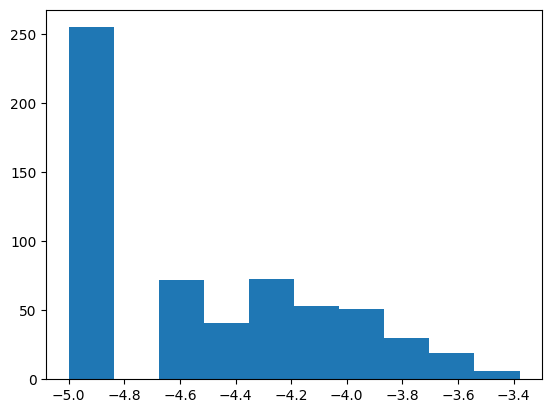

In [19]:
# this is your posterior - predicted value of the luminosity function...?
# maybe log it
plt.hist(x_train[:, 0])


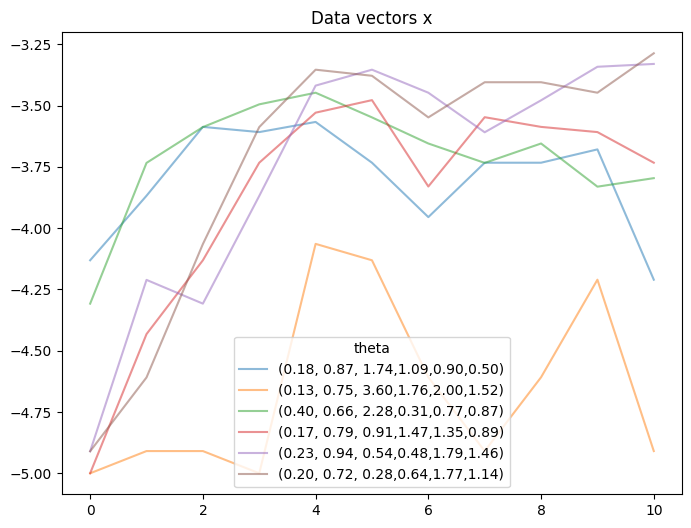

In [20]:
# Plot some examples of the data
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(6):
    ind = np.random.randint(len(theta_train))
    ax.plot(x_train[ind], alpha=0.5, label=f'({theta_train[ind, 0]:.2f}, {theta_train[ind, 1]:.2f}, {theta_train[ind, 2]:.2f},{theta_train[ind, 3]:.2f},{theta_train[ind, 4]:.2f},{theta_train[ind, 5]:.2f})')
#ax.set_yscale('log')
ax.legend(title='theta')
ax.set_title('Data vectors x')
plt.show()

The SBIRunner object will handle all of the data normalization and model training for us. We just need to provide it with:
- our parameter prior
- our inference type (SNPE/SNLE/SNRE)
- our desired neural network architecture
- our training hyperparameters

On the backend, it does a validation split among the provided training data, trains the neural networks with an Adam optimizer, and enforces an early stopping criterion to prevent overfitting. All the parameters of these processes can be independently configured.

In [21]:
def initialise_priors(device="cuda", astro=True, dust=True):

    combined_priors = []

    if astro:
        base_dist1 = Uniform(
            torch.log(torch.tensor([0.25], device=device)),
            torch.log(torch.tensor([4], device=device)),
        )
        base_dist2 = Uniform(
            torch.log(torch.tensor([0.5], device=device)),
            torch.log(torch.tensor([2], device=device)),
        )
        astro_prior1 = TransformedDistribution(base_dist1, ExpTransform())
        astro_prior2 = TransformedDistribution(base_dist2, ExpTransform())
        omega_prior = Uniform(
            torch.tensor([0.1], device=device),
            torch.tensor([0.5], device=device),
        )
        sigma8_prior = Uniform(
            torch.tensor([0.6], device=device),
            torch.tensor([1.0], device=device),
        )
        combined_priors += [
            omega_prior,# prior for omega m, between 0.1 and 0.5: uniform
            sigma8_prior,# prior for sigma_8, between 0.6 and 1: uniform
            astro_prior1,# prior for A_SN1, between 0.25 and 4: exponential
            astro_prior1,# prior for A_AGN1, between 0.25 and 4: exponential
            astro_prior2,# prior for A_SN2, between 0.5 and 2: exponential
            astro_prior2,# prior for A_AGN2, between 0.5 and 2: exponential
        ]

    prior = process_prior(combined_priors)

    return prior[0]

In [22]:
prior = initialise_priors()
print(prior)

MultipleIndependent()


In [23]:
# make a dataloader
loader = NumpyLoader(x=x_train, theta=theta_train)

# instantiate your neural networks to be used as an ensemble
# are the NN here setting our likelihoods?
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf')#, hidden_features=50, num_transforms=5),
    #ili.utils.load_nde_sbi(engine='NPE', model='mdn', hidden_features=50, num_components=6)
]

# hyperparameter search
# for batch_size in [4, 8, 16, 32]:
# for learning_rate in [1e-2, 1e-3, 1e-4]:
# for hidden_features in [50, 100, 200]
# for num_components in [6, 12, 18]

results = {}

for batch_size in [10, 20, 30, 40]:
    
    # define training arguments
    train_args = {
        'training_batch_size': batch_size, # batch_size
        'learning_rate': 1e-2 # learning_rate
    }

#             training_batch_size=50,
#             learning_rate=5e-4,
#             validation_fraction=0.1,
#             stop_after_epochs=20,
#             clip_max_norm=5,

    # initialize the trainer
    runner = InferenceRunner.load(
        backend='sbi',
        engine='NPE',
        prior=prior,
        nets=nets,
        device=device,
        embedding_net=None,
        train_args=train_args,
        proposal=None,
        out_dir=None
    )

    # train the model
    posterior_ensemble, summaries = runner(loader=loader, seed=1)
    # seed fixes the validation set 
    
    # Store the outputs
    results[batch_size] = {
        'posterior_ensemble': posterior_ensemble,
        'summaries': summaries
    }

INFO:root:MODEL INFERENCE CLASS: NPE


AssertionError: Prior device 'cpu' must match training device 'cuda:0'. When training on GPU make sure to pass a prior initialized on the GPU as well, e.g., prior = torch.distributions.Normal(torch.zeros(2, device='cuda'), scale=1.0)`.

In [ ]:
# Assuming your results dictionary is named 'results'
batch_size_of_interest = 10

# Check if the batch size exists in the results
if batch_size_of_interest in results:
    data = results[batch_size_of_interest]
    
    # Access the 'posterior_ensemble' and 'summaries'
    posterior_ensemble = data['posterior_ensemble']
    summaries = data['summaries']
    
    # Print or further process the retrieved data
    print(f"Posterior Ensemble for batch size {batch_size_of_interest}:")
    print(posterior_ensemble)
    
    print(f"Summaries for batch size {batch_size_of_interest}:")
    for summary in summaries:
        print(summary)
else:
    print(f"No results found for batch size {batch_size_of_interest}.")


In [ ]:
posterior_ensemble

Here, the output of the runner is a posterior model and a log of training statistics. The posterior model is a [NeuralPosteriorEnsemble](https://github.com/mackelab/sbi/blob/6c4fa7a6fd254d48d0c18640c832f2d80ab2257a/sbi/utils/posterior_ensemble.py#L19) model and automatically combines samples and probability densities from its component networks.

In [ ]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

# from my understanding, as the gap between the validation and train set gets bigger the results are getting worse.
# The point where val is maximised is the best result (around -2.4), which is the best_validation_log_prob


In [ ]:
print(f"Shape of theta: {theta_train.shape}")
print(f"Shape of x: {x_train.shape}")


In [ ]:
# Now, SBIRunner returns a custom class instance to be able to pass signature strings
# This class has simply for attributes a NeuralPosteriorEstimate and a string list 
print(posterior_ensemble.signatures)

# choose a random input
seed_in = 49
np.random.seed(seed_in)
ind = np.random.randint(len(theta_train))

# generate samples from the posterior using accept/reject sampling
seed_samp = 32
torch.manual_seed(seed_samp)
samples = posterior_ensemble.sample((1000,), torch.Tensor(x_train[ind]).to(device))

# calculate the log_prob for each sample
log_prob = posterior_ensemble.log_prob(samples, torch.Tensor(x_train[ind]).to(device))

samples = samples.cpu().numpy()
log_prob = log_prob.cpu().numpy()

In [ ]:
print(ind)

In [ ]:

# samples is the posterior, P(theta_hat | y_i), conditioned on data y_i, generated from theta_i (prior)
plt.hist(samples[:, 2])
print('Prior:',theta[ind, 2])
print('Histogram is Posterior:')

In [ ]:
# Create subplots
fig, axs = plt.subplots(1, 5, figsize=(15, 6), gridspec_kw={'width_ratios': [1, 1, 1, 1, 1, 0.05]})

for i in range(5):  # Only iterate over 5 pairs to avoid index out of range
    axs[i].plot(theta_train[ind, i], theta_train[ind, i+1], 'r+', markersize=10, label='true')
    im = axs[i].scatter(samples[:, i], samples[:, i+1], c=log_prob, s=4, label='samples')
    axs[i].set_aspect('equal')
    axs[i].set_xlim(0, 1)
    axs[i].set_ylim(0, 1)
    axs[i].set_xlabel(f'$\\theta_{i}$')
    axs[i].set_ylabel(f'$\\theta_{i+1}$')
    axs[i].legend()

# Add a colorbar for the scatter plots
plt.colorbar(im, label='log probability', use_gridspec=True, cax=axs[5])

print('True values are from our prior, and theta 0-6 are our possible outputs for the observed data')
plt.show()

In [ ]:
# Plot the posterior samples and the true value for all pairs of theta values
fig, axs = plt.subplots(5, 5, figsize=(15, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(5):
    for j in range(5):
        if i != j:
            axs[i, j].plot(theta_train[ind, i], theta_train[ind, j], 'r+', markersize=10, label='true')
            im = axs[i, j].scatter(samples[:, i], samples[:, j], c=log_prob, s=4, label='samples', cmap='viridis')
            axs[i, j].set_xlabel(f'$\\theta_{i}$')
            axs[i, j].set_ylabel(f'$\\theta_{j}$')
            axs[i, j].legend()
        else:
            axs[i, j].axis('off')

# Add a color bar for log probability
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='log probability')

plt.show()

print('True values are marked with red pluses, and the pairs of theta values are plotted against each other.')


In [ ]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(6)] # change to parameter names
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = x_train[ind], theta_fid=theta_train[ind]
)

In [ ]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(5)] # change to parameter names
)

fig = metric(
    posterior=posterior_ensemble,
    x_obs = x_test[ind], theta_fid=theta_test[ind]
)

### Using the ensemble of trained posteriors models
By default, running a SampleBasedMEtric with posterior from above will compute the metrics using the ensemble model. That is to say the ensemble is considered one model, with the weights of each posterior in the ensemble being the val_log_prob.

In [ ]:
# Drawing samples from the ensemble posterior

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(6)],
    plot_list = ["coverage", "histogram", "predictions", "tarp"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=x_test, theta=theta
)

In the ensemble model, it looks like our posteriors are well-calibrated when evaluated on marginal distributions, but slightly negatively biased in the multivariate TARP coverage.

### Evaluating each trained posterior in the ensemble
Below, we compute separately each SampleBasedMetric for every posterior in the ensemble.

In [ ]:
# Drawing samples for each posterior in the ensemble
# First the MAF posterior
metric = PosteriorCoverage(num_samples=1000, 
    sample_method='direct', labels=[f'$\\theta_{i}$' for i in range(3)],
    plot_list = ["coverage", "histogram", "predictions", "tarp"])

fig = metric(
    posterior=posterior_ensemble.posteriors[0],
    x=x_test theta=theta
)

In [ ]:
# Then for the MDN
fig = metric(
    posterior=posterior_ensemble.posteriors[1],
    x=x_test, theta=theta
)

From these results, we see that we are largely consistent and calibrated in the univariate coverage, with some slight negative bias shown in the multivariate coverage. It looks like the MAF model has slightly better constraints than the MDN model, while retaining the same calibration.